## Fwrf gabor model, 2014 imagery.rf data


In [1]:
import numpy as np
import pandas as pd
import h5py
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from imagery_rf_field.src.glmd_betas import *
from os.path import join
from time import time
from glob import glob
from scipy.io import loadmat
from scipy.stats import pearsonr
from hrf_fitting.src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu, bigmult
from hrf_fitting.src.feature_weighted_rf_models import train_fwrf_model
from hrf_fitting.src.gabor_feature_dictionaries import gabor_feature_maps
from math import atan2, degrees

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X


### Step 0: load data

#### find data files

In [2]:
saving_spot = '/media/tnaselar/Data/scratch/'

####with z-score
# beta_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_with_Zscore/betas/'
# file_exp = '%s_all_runs_BETAs_w_zscore.mat'

####withOUT z-score
beta_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_withOUT_Zscore/betas/'
file_exp = '%s_all_runs_BETAs_no_zs.mat'
subject = 'TN'
stim_loc = '/musc.repo/mri/7T.cmrr/Presentation/imagery.rf.7T.July.2014/'
cond_file_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_withOUT_Zscore/condit_names/%s_condit_names.mat' %(subject)
mask_path = '/media/tnaselar/Data/imagery_rf.2014/masks/%s_mask.nii.gz' %(subject)

#### load data

In [3]:
beta_df = load_betas_from_mat_file(join(beta_path,file_exp) %(subject))
mask = load_mask_from_nii(mask_path)

In [4]:
stim_df = load_stim_from_mat_file(cond_file_path,stim_loc)

In [5]:
mask = load_mask_from_nii(mask_path)

In [6]:
print 'volume dimensions: %s' %(mask.shape,)
print 'number of voxels: %d' %(np.sum(mask))

volume dimensions: (130, 130, 70)
number of voxels: 432342


#### instantiate simple class to gather all the data together

In [7]:
fMRI = imagery_rf_dataset(subject, beta_df, stim_df, mask)

#### eyeball description of each condition

In [8]:
fMRI.stim.head(72)

,run,category,object_name,location,image_name
0,1img,vehicle,fire_truck,north,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
1,1img,bird,birds,southeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
2,1img,few_humans,baby,east,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
3,1img,few_humans,baby,west,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
4,1img,few_humans,baby,southwest,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
5,1img,many_humans,audience,south,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
6,1img,part_of_building,building,east,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
7,1img,few_humans,baby,northeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
8,1img,bird,birds,southwest,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
9,1img,many_humans,audience,northeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...


#### look at one of the stimuli

/musc.repo/mri/7T.cmrr/Presentation/imagery.rf.7T.July.2014/imagery_005/frame_files/000718.006.02.image.png
audience
southwest


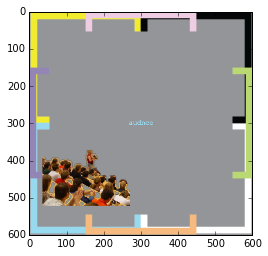

In [9]:
cond_dx = 512
img = fMRI.get_condition_stimuli(cond_dx)
plt.imshow(img)
print fMRI.stim.loc[cond_dx,'image_name']
print fMRI.stim.loc[cond_dx,'object_name']
print fMRI.stim.loc[cond_dx,'location']

#### separate out the imagery and perception indices

In [10]:
idx = {}
idx['img'] = fMRI.get_stimuli_with('run','img').index
idx['pcp'] = fMRI.get_stimuli_with('run','pcp').index


print 'number of imagery stimuli: %d' %(len(idx['img']))
print 'number of perception stimuli: %d' %(len(idx['pcp']))

number of imagery stimuli: 512
number of perception stimuli: 512


### Step 1: specify gabor features

#### calculate deg_per_stimulus

In [11]:
native_stim_size = 600  ##pixels
viewing_distance = 100 ##cm
viewing_area = 38.8 ##cm

# Calculate the number of degrees that correspond to a single pixel. This will
# generally be a very small value, something like 0.03.
deg_per_px = degrees(atan2(.5*viewing_area, viewing_distance)) / (.5*native_stim_size)
print '%f pixels correspond to one degree' % (1./deg_per_px)
# Calculate the size of the stimulus in degrees
size_in_deg = native_stim_size * deg_per_px
print 'The size of the stimulus is %s pixels and %s visual degrees' % (native_stim_size, size_in_deg)



27.324889 pixels correspond to one degree
The size of the stimulus is 600 pixels and 21.958003465 visual degrees


#### design gabor wavelets

In [12]:
n_orientations = 2
deg_per_stimulus = 21.958
lowest_sp_freq = .114 ##cyc/deg
highest_sp_freq = 4.0
num_sp_freq = 3
pix_per_cycle = 2.13333333
complex_cell = True
n_colors = 1 ##let's do grayscale first
diams_per_filter = 4
cycles_per_radius = 2.0

print 'D = total number of features = %d' %(n_orientations * num_sp_freq)

D = total number of features = 6


In [13]:
gfm = gabor_feature_maps(n_orientations,
                         deg_per_stimulus,
                         (lowest_sp_freq,highest_sp_freq,num_sp_freq),
                         pix_per_cycle=pix_per_cycle,complex_cell=complex_cell,
                         diams_per_filter = diams_per_filter,
                         cycles_per_radius = cycles_per_radius,
                         color_channels=n_colors)

In [14]:
gfm.gbr_table.head(9)

,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
0,0.114000,16,140.350877,5.340186,34,17.543860,0.000000
1,0.675278,16,23.693955,31.632529,34,2.961744,0.000000
2,4.000000,16,4.000000,187.374933,34,0.500000,0.000000
3,0.114000,16,140.350877,5.340186,34,17.543860,1.570796
4,0.675278,16,23.693955,31.632529,34,2.961744,1.570796
5,4.000000,16,4.000000,187.374933,34,0.500000,1.570796


In [15]:
gfm.filter_stack.shape

(6, 1, 34, 34)

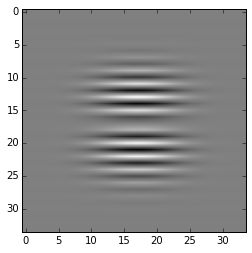

In [16]:
o =  1##choose an orientation
plt.imshow(np.imag(gfm.filter_stack[o,0,:,:]), cmap='gray')

### Step 2: Design receptive field grid

In [17]:
deg_per_radius = (1., 4., 2) ##rf sizes in degrees (smallest, largest, number of sizes)
spacing = 2.5 ##spacing between rf's in degrees
rf = receptive_fields(deg_per_stimulus,deg_per_radius,spacing)

In [18]:
rf.rf_table.deg_per_radius.unique()

array([ 1.,  4.])

In [19]:
print 'G = number of rf models = %d' %(rf.rf_table.shape[0])

G = number of rf models = 128


### Step 3: Construct a model space

#### specify activation function

In [20]:
log_act_func = lambda x: np.log(1+np.sqrt(x))

#### instantiate a model space object

In [21]:
##just read in one image for now to create the feature dictionary that will initiate the model_space object
if n_colors < 3:
    ##np.newaxis,np.newaxis = time,color
    init_image = np.array(fMRI.get_condition_stimuli(0,output = 'PIL').convert('L'))[np.newaxis,np.newaxis] 
else:
    init_image = fMRI.get_condition_stimuli(0)
    init_image = np.rollaxis(init_image,axis=2,start=0)[np.newaxis] ##<<newaxis for time only

init_feature_dict = gfm.create_feature_maps(init_image)

allocating memory for feature maps
constructing feature maps
feature 0 took 0.007125 s.
feature 1 took 0.002018 s.
feature 2 took 0.005896 s.
feature 3 took 0.001222 s.
feature 4 took 0.001999 s.
feature 5 took 0.005282 s.


In [22]:
ms = {}
ms['pcp'] = model_space(init_feature_dict, rf, activation_function = log_act_func)
ms['img'] = model_space(init_feature_dict, rf, activation_function = log_act_func)

### Step 4: load up all stimuli at the max feature resolution

In [23]:
max_feature_res = np.max(ms['pcp'].feature_resolutions.values())

load_stim_func = lambda dx: np.array(fMRI.get_condition_stimuli(dx,output = 'PIL',image_size=(max_feature_res,max_feature_res)).convert('L'))[np.newaxis,np.newaxis] 

In [24]:
load_stim_func(0).shape

(1, 1, 187, 187)

In [25]:
stimuli = {}
stimuli['pcp'] = np.concatenate(map(load_stim_func,
                                 idx['pcp']),
                             axis=0)


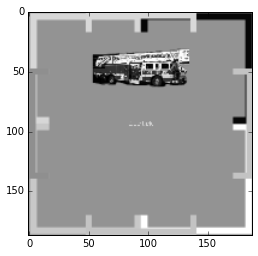

In [26]:
plt.imshow(stimuli['pcp'][0,0,:,:], cmap='gray')

In [27]:
stimuli['img'] = np.concatenate(map(load_stim_func,
                                 idx['img']),
                             axis=0)

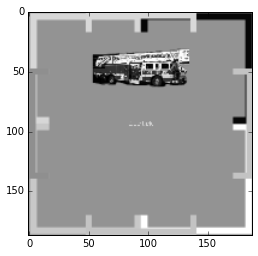

In [28]:
plt.imshow(stimuli['img'][0,0,:,:],cmap='gray')

### Step 5: train the perception and imagery models

#### train/test split

In [31]:
val_frac = 0.1
nvox = 1000 #fMRI.betas.shape[0]

#### train the model!

In [32]:
mst = {}
params = {}
params['pcp'] = {}
params['img'] = {}
pred = {}
val_cc = {}
for state in ['pcp', 'img']:
    print '==========================================================%s' %(state)
    ##build feature diction. overwrite across state
    feature_dict = gfm.create_feature_maps(stimuli[state])
    ##build model space tensor
    mst[state] = ms[state].construct_model_space_tensor(feature_dict, normalize=False)
    mst[state] = ms[state].normalize_model_space_tensor(mst[state],save=True)
    n_stim = len(idx[state])
    Tval = int(np.floor(val_frac*n_stim))

    Ttrn = n_stim - Tval
    val_idx = np.linspace(0,n_stim,endpoint=False,num=Tval,dtype='int')
    trn_idx = np.setdiff1d(np.arange(n_stim), val_idx)
    trn_voxel_data = fMRI.betas[0:nvox, idx[state][trn_idx]].T
    val_voxel_data = fMRI.betas[0:nvox, idx[state][val_idx]].T
    training_mst = mst[state][:,trn_idx,:]
    validation_mst = mst[state][:,val_idx,:]
    params[state]['fvl'],params[state]['ffw'],params[state]['frf'],params[state]['beh'] = train_fwrf_model(training_mst,
                                                                                                           trn_voxel_data,
                                                                                                           initial_feature_weights='zeros',
                                                                                                           voxel_binsize = 25000,
                                                                                                           rf_grid_binsize=10,
                                                                                                           learning_rate=10**(-5.),
                                                                                                           max_iters = 150,
                                                                                                           early_stop_fraction=0.15,
                                                                                                           report_every = 50)
    ##generate predictions
    frf = params[state]['frf']
    ffw = params[state]['ffw']
    pred[state] = np.zeros((Tval,nvox))
    for v in range(nvox): 
        pred[state][:,v] = np.squeeze(bigmult(validation_mst[np.newaxis,frf[v],:,:],
                                       ffw[np.newaxis,:,v, np.newaxis]))
    
    val_cc[state] = []
    for v in range(nvox): 
        cc = pearsonr(val_voxel_data[:,v],pred[state][:,v])
        if not np.isnan(cc[0]):
            val_cc[state].append(cc[0])
        else:
            val_cc[state].append(0) 

==========================================================pcp
allocating memory for feature maps
constructing feature maps
feature 0 took 0.044980 s.
feature 1 took 0.235113 s.
feature 2 took 1.953310 s.
feature 3 took 0.044709 s.
feature 4 took 0.219774 s.
feature 5 took 1.857143 s.
-----------feature: 0
at pixel resolution 5 the following rfs will default to 0: (array([ 1.,  4.]),)
-----------feature: 1
-----------feature: 2
-----------feature: 3
at pixel resolution 5 the following rfs will default to 0: (array([ 1.,  4.]),)
-----------feature: 4
-----------feature: 5
converted nans to nums
model_space_tensor has been z-scored
--------------voxels from 0 to 1000
--------candiate rf models 0 to 11
-------
errors: 81552.090356
change in best rf: 5599.000000
norm of feature weights: 2.622841
improvements: 11000
0.0166521072388
-------
errors: 81059.238868
change in best rf: 8.000000
norm of feature weights: 102.013985
improvements: 4428
0.637988090515
-------
errors: 80853.453292
change

/musc.repo/Docs/tnaselar/code/Python/hrf_fitting/src/feature_weighted_rf_models.py:233: UserWarning: not saving because constants are already defined
  warn('not saving because constants are already defined')


KeyboardInterrupt: 

### Step 6: analysis

#### loss history

In [ ]:
skip = 10
for ii,state in enumerate(['pcp', 'img']):
    beh = params[state]['beh']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    diff = beh[:,slice(0,-1,skip)]-beh[0,slice(0,-1,skip)]
    _=plt.plot(diff)
    plt.ylim([np.min(diff.ravel()),np.max(diff.ravel())])
plt.tight_layout()

In [ ]:
for ii,state in enumerate(['pcp', 'img']):
    beh = params[state]['beh']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    _=plt.hist(np.nan_to_num(beh[0,:]-np.min(beh,axis=0)),100)
    plt.yscale('log')

#### rf's

In [ ]:
for ii,state in enumerate(['pcp', 'img']):
    frf = params[state]['frf']
    plt.subplot(1,2,ii+1)
    _=plt.hist(frf,ms[state].receptive_fields.G)
    plt.xlabel('smaller-->bigger')
    plt.title(state)

In [ ]:
for ii,state in enumerate(['pcp', 'img']):
    frf = params[state]['frf']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    plt.imshow(np.sum(ms[state].receptive_fields.make_rf_stack(64, min_pix_per_radius=1)[frf,:,:], axis=0), cmap='hot')

#### prediction accuracy histograms

In [ ]:
count_thresh = .5
plt.figure(figsize = (10,5))
for ii,state in enumerate(['pcp', 'img']):
    plt.subplot(2,1,ii+1)
    _=plt.hist(val_cc[state],100)
    plt.yscale('log')
    plt.ylim([10**0, 10**4])
    plt.xlim([-1, 1.])
    plt.title(state)
    print 'number of voxels with cc > %f, %s: %d' %(count_thresh,state,np.sum(map(lambda x: x > count_thresh, val_cc[state])))

In [ ]:
plt.figure(figsize = (10,5))
for ii,state in enumerate(['pcp', 'img']):
    values, base = np.histogram(val_cc[state], bins=100)
    #evaluate the cumulative
    cumulative = np.cumsum(values)
    # plot the cumulative function
    plt.plot(base[:-1], cumulative, hold=True,label=state, linewidth=3)#     plt.yscale('log')
#     plt.ylim([10**0, 10**4])
#     plt.xlim([-1, 1.])
    
plt.legend(loc='best')    

In [ ]:
pred['img']

#### prediction accuracy head-to-head

In [ ]:
rng = np.linspace(-.6, .6, num=50)
plt.plot(val_cc['pcp'], val_cc['img'], '.');
plt.ylabel('img')
plt.xlabel('pcp')
plt.plot(rng, rng)
plt.axes().set_aspect(1)
plt.xlim([-1, 1])
plt.ylim([-1, 1])

#### prediction accuracy volumes

In [ ]:
from IPython.display import Image as ipyImage

In [ ]:
def view_vol_data(data_object, data_vol,save_to = None):
    cur = data_object.mask.ravel(order=data_object.order).copy()
    cur[cur > 0] = data_vol
    view_vol = cur.reshape(data_object.shape,order=data_object.order)
    if save_to:
        nib.save(nib.Nifti1Image(view_vol,affine=np.eye(4)),save_to)
    else:
        return view_vol

##### perception

In [ ]:
view_vol_data(fMRI,val_cc['pcp'], save_to = '/media/tnaselar/Data/scratch/pcp_val_cc_'+subject )

In [ ]:
# ipyImage(filename='/home/tnaselar/Dropbox/Manuscripts/imagery.receptive.fields/First.try.pcp.val_cc.TN.png')

##### imagery

In [ ]:
view_vol_data(fMRI,val_cc['img'], save_to = '/media/tnaselar/Data/scratch/img_val_cc_'+subject )

In [ ]:
# ipyImage(filename='/home/tnaselar/Dropbox/Manuscripts/imagery.receptive.fields/First.imagery.val_cc.TN.png')

### Step 6: Save objects

In [ ]:
def act_func(x):
    return log_act_func(x)

import pickle
saving_place = '/media/tnaselar/Data/imagery_rf.2014/model_runs/'
saving_file = 'model_space_'+subject+'.p'
for ii,state in enumerate(['pcp', 'img']):
    ms[state].optimal_feature_weights = params[state]['ffw']
    ms[state].optimal_rf_model = params[state]['frf']
    ms[state].val_cc = val_cc[state]
    ms[state].activation_function = act_func
    pickle.dump(ms[state], open( join(saving_place, saving_file), "wb"))